In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as pt

AR_data = pd.read_csv('C:/Users/Drew/Downloads/foot_traffic.csv')
MA_data = pd.read_csv('C:/Users/Drew/Downloads/widget_sales.csv')
ARMA_data = pd.read_csv('C:/Users/Drew/Downloads/bandwidth.csv')

In [2]:
AR_data.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


# AR_Data with ARIMA

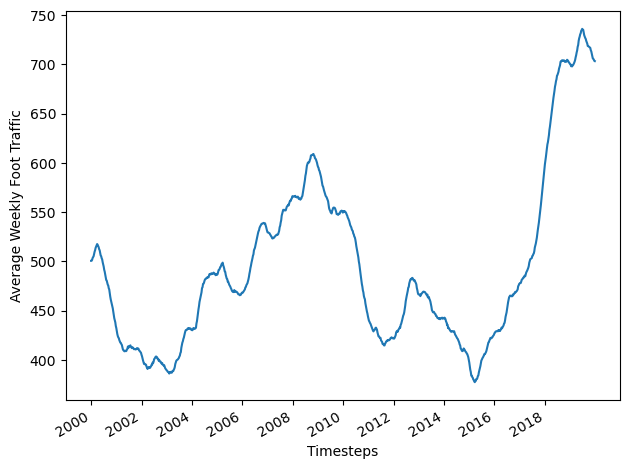

In [3]:
fig, ax = pt.subplots()

ax.plot(AR_data['foot_traffic'])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Average Weekly Foot Traffic')
pt.xticks(np.arange(0,1000, 100), np.arange(2000,2020,2))
fig.autofmt_xdate()
pt.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(AR_data['foot_traffic'])
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-value: {ADF_result[1]}')

 ADF Statistic: -1.1758885999240796
 P-value: 0.6838808917896169


In [5]:
AR_data_diff = np.diff(AR_data['foot_traffic'], n=1)

In [6]:
ADF_result_diff = adfuller(AR_data_diff)
print(f' ADF Statistic: {ADF_result_diff[0]}')
print(f' P-value: {ADF_result_diff[1]}')

 ADF Statistic: -5.268231347422036
 P-value: 6.3693176547815014e-06


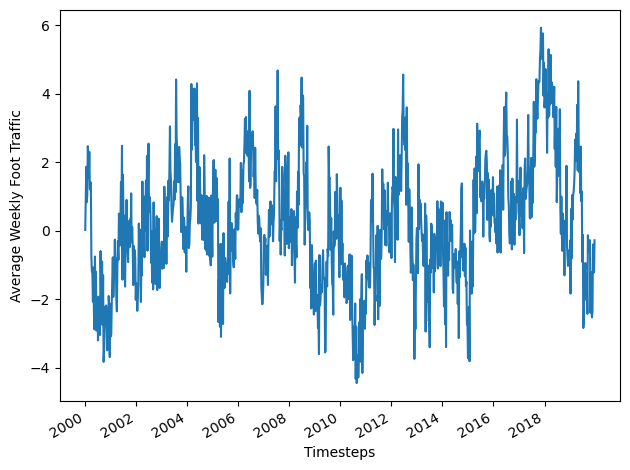

In [7]:
fig, ax = pt.subplots()

ax.plot(AR_data_diff)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Average Weekly Foot Traffic')
pt.xticks(np.arange(0,1000, 100), np.arange(2000,2020,2))
fig.autofmt_xdate()
pt.tight_layout()

The mean and variance is constant as well as there is no seasonality or trend in the data. Hence, stationary.

In [8]:
print(len(AR_data))

1000


In [9]:
train = AR_data[:-200]
test = AR_data[-200:]

print(len(train))
print(len(test))

800
200


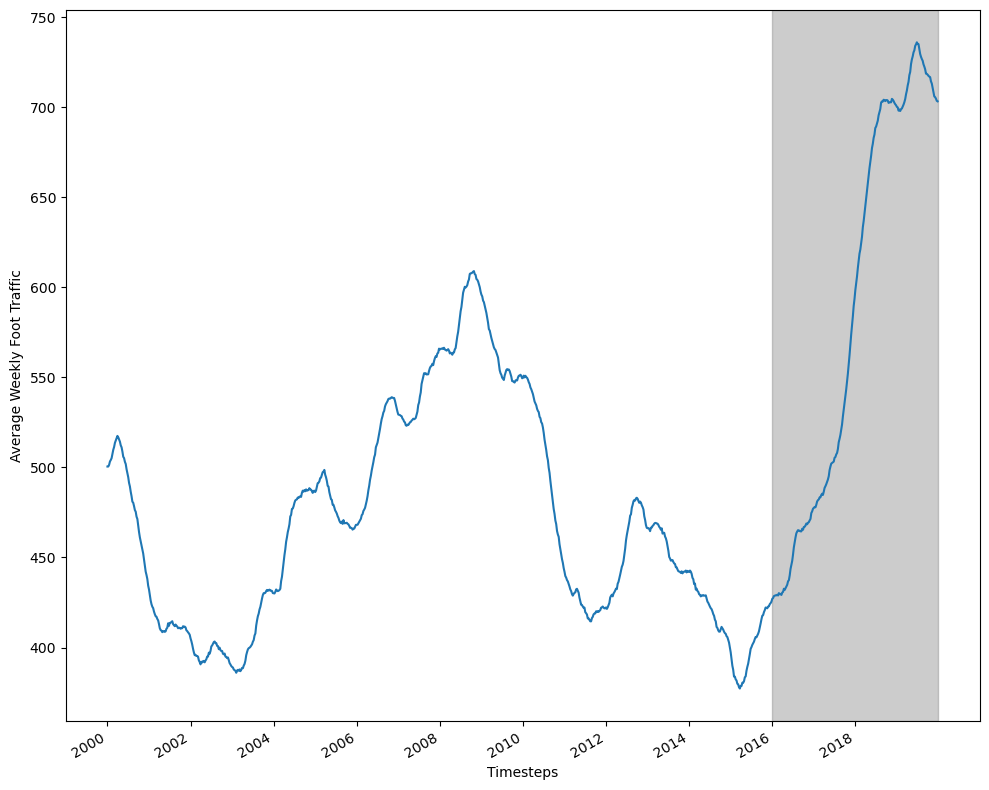

In [10]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(AR_data['foot_traffic'])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Average Weekly Foot Traffic')
ax.axvspan(800,1000, color="#808080", alpha=0.4)
pt.xticks(np.arange(0,1000, 100), np.arange(2000,2020,2))
fig.autofmt_xdate()
pt.tight_layout()

In [11]:
from itertools import product

ps = range(0,4,1)
qs = range(0,4,1)
d = 1 

ARIMA_order_list = list(product(ps,qs))

In [12]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = [] #initialize an empty list to store results
    for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.
        try: 
            #Fit an ARIMA(p,d,q) model using the SARIMAX function. 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic #Calculate the model AIC
        results.append([order,aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sorting the results from ascending order. The lower the AIC the better.
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
result_data = optimize_ARIMA(train, ARIMA_order_list, d)
result_data

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\903790325.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 1)",2246.079564
1,"(1, 3)",2247.019782
2,"(3, 2)",2248.072973
3,"(3, 0)",2248.754077
4,"(2, 3)",2248.994144
5,"(3, 3)",2249.321564
6,"(2, 1)",2250.181016
7,"(2, 2)",2250.300545
8,"(2, 0)",2254.336940
9,"(1, 2)",2257.805421


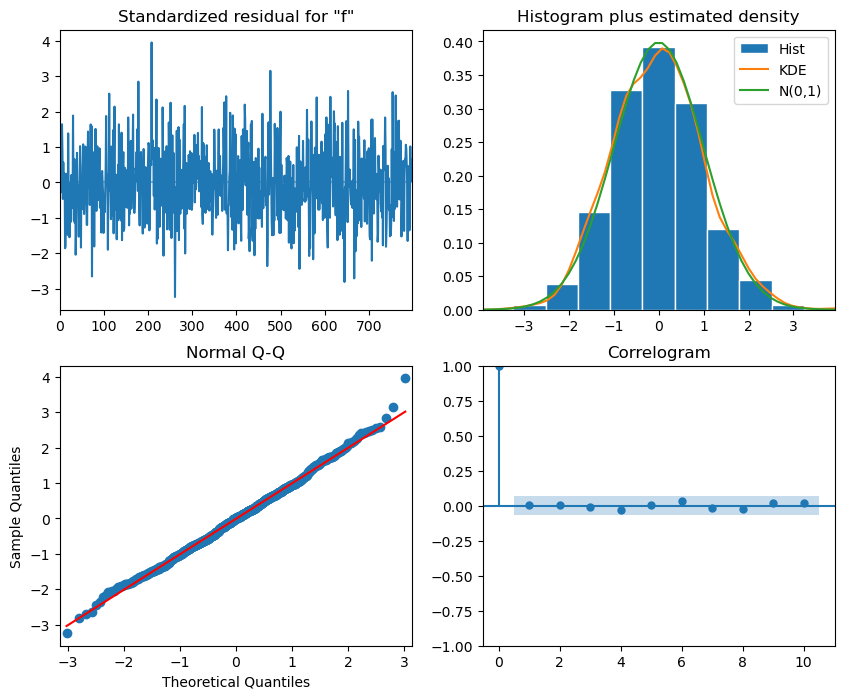

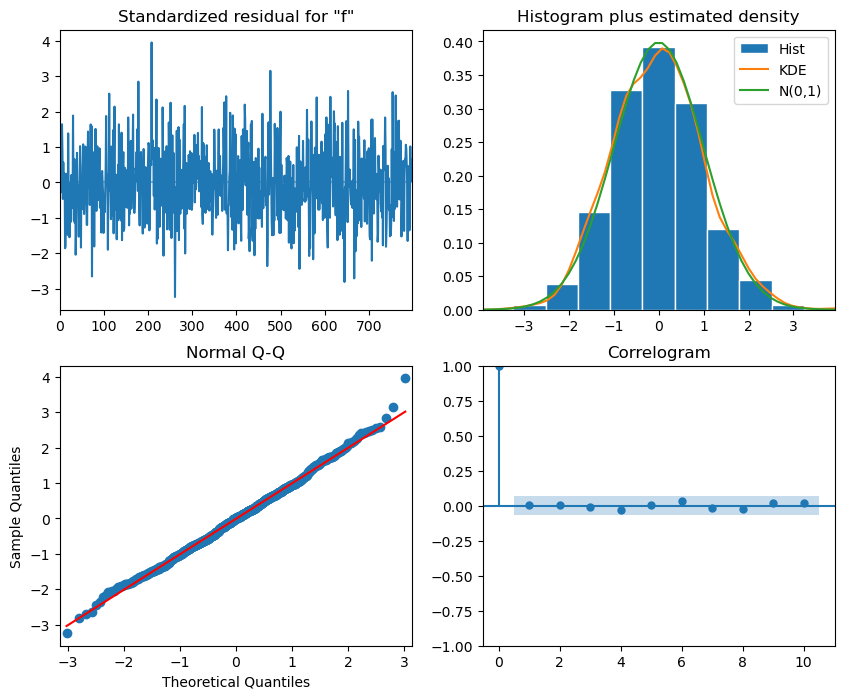

In [14]:
ARIMA_model = SARIMAX(train, order=(3,1,1), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

residuals = ARIMA_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.000004   0.998319
2   0.002590   0.998706
3   0.010091   0.999731
4   0.010213   0.999987
5   0.010420   0.999999
6   0.019352   1.000000
7   0.021657   1.000000
8   0.022414   1.000000
9   0.023552   1.000000
10  0.023910   1.000000


In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [17]:
TRAIN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(AR_data, TRAIN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(AR_data, TRAIN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(AR_data, TRAIN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last'] = pred_last
test['pred_ARIMA'] = pred_ARIMA

test.head()

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\3430662673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\3430662673.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last'] = pred_last
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\3430662673.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,foot_traffic,pred_mean,pred_last,pred_ARIMA
800,427.026123,469.637066,425.457180,426.131734
801,427.475914,469.583869,427.026123,427.893490
802,428.562242,469.531366,427.475914,428.503147
803,428.793177,469.480345,428.562242,429.223521
804,429.009538,469.429740,428.793177,429.394902


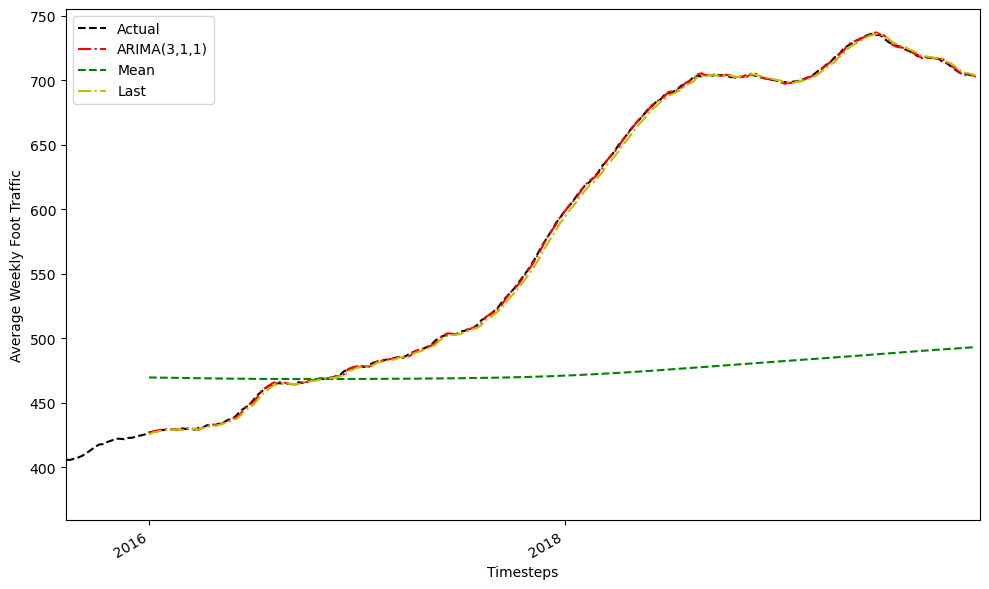

In [18]:
fig, ax = pt.subplots(figsize=(10,6))

ax.plot(AR_data['foot_traffic'], 'k--', label='Actual')
ax.plot(test['pred_ARIMA'], 'r-.', label='ARIMA(3,1,1)')
ax.plot(test['pred_mean'], 'g--', label="Mean")
ax.plot(test['pred_last'], 'y-.', label='Last')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Average Weekly Foot Traffic')
pt.xticks(np.arange(0,1000, 100), np.arange(2000,2020,2))
ax.set_xlim(780,1000)
fig.autofmt_xdate()
pt.tight_layout()

In [19]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
ARIMA_mape = mape(test['foot_traffic'], test['pred_ARIMA'])
print(ARIMA_mape)

0.13666422479496745


In [21]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['foot_traffic'], test['pred_ARIMA'])
print(mae)

0.775893717778834


# MA_data with ARIMA 

In [22]:
MA_data.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [23]:
MA_data.describe()

,widget_sales
count,500.000000
mean,46.969858
std,15.382473
min,20.674946
25%,32.507149
50%,47.667536
75%,59.425693
max,82.922496


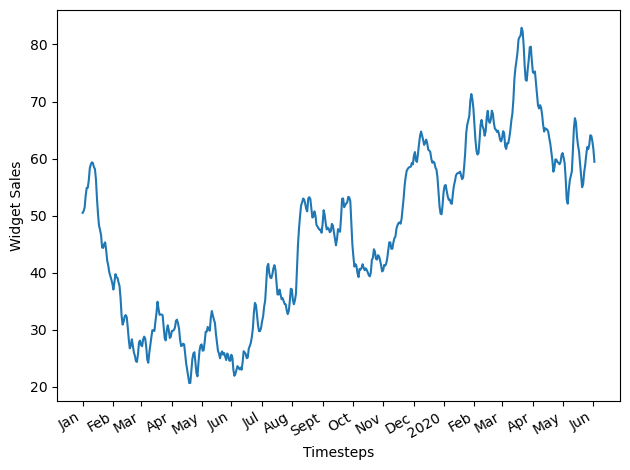

In [24]:
fig, ax = pt.subplots()

ax.plot(MA_data['widget_sales'])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Widget Sales')
pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])
fig.autofmt_xdate()
pt.tight_layout()

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
ADF_result = adfuller(MA_data['widget_sales'])
print(f' ADF Statistics: {ADF_result[0]}')
print(f' P-Value: {ADF_result[1]}')

 ADF Statistics: -1.512166206935896
 P-Value: 0.5274845352272648


In [27]:
MA_data_diff = np.diff(MA_data['widget_sales'], n=1)

In [28]:
ADF_result_diff = adfuller(MA_data_diff)
print(f' ADF Statistics: {ADF_result_diff[0]}')
print(f' P-Value: {ADF_result_diff[1]}')

 ADF Statistics: -10.576657780341957
 P-Value: 7.076922818587346e-19


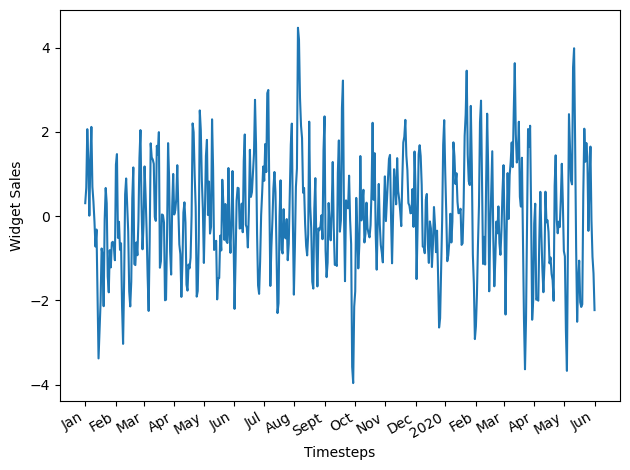

In [29]:
fig, ax = pt.subplots()

ax.plot(MA_data_diff)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Widget Sales')
pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])
fig.autofmt_xdate()
pt.tight_layout()

In [30]:
from itertools import product

ps = range(0,4,1)
qs = range(0,4,1)
d = 1 

MA_order_list = list(product(ps,qs))

In [31]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = [] #initialize an empty list to store results
    for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.
        try: 
            #Fit an ARIMA(p,d,q) model using the SARIMAX function. 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic #Calculate the model AIC
        results.append([order,aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sorting the results from ascending order. The lower the AIC the better.
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [32]:
train = MA_data[:-100]
test = MA_data[-100:]

print(len(train))
print(len(test))

400
100


In [33]:
result_data = optimize_ARIMA(train, MA_order_list, d)
result_data

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\903790325.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(0, 2)",1104.800251
1,"(2, 1)",1105.428357
2,"(1, 1)",1106.095701
3,"(0, 3)",1106.347930
4,"(1, 2)",1106.484793
5,"(3, 0)",1106.798061
6,"(3, 1)",1106.949897
7,"(2, 2)",1107.203027
8,"(2, 3)",1107.330989
9,"(3, 3)",1107.772381


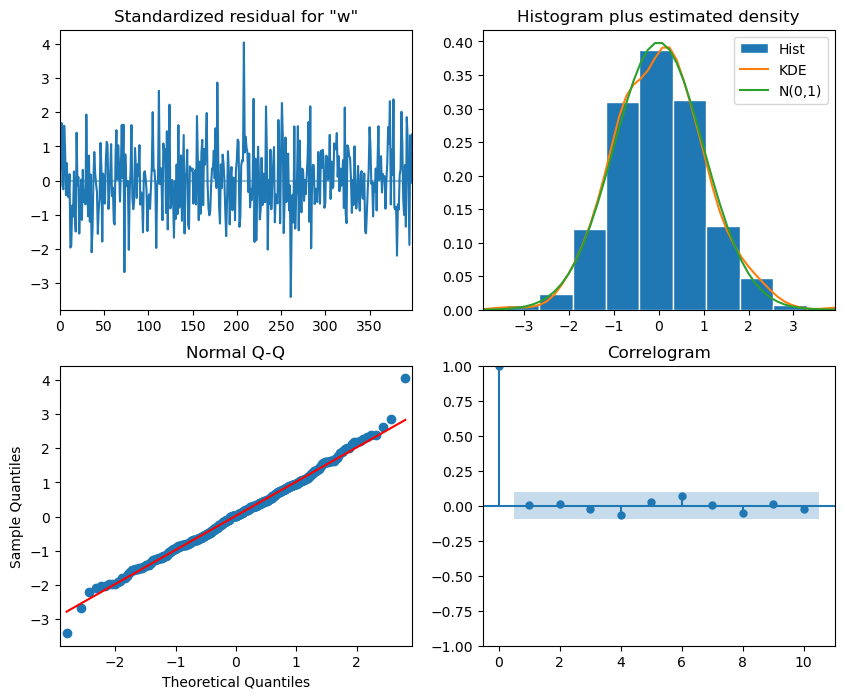

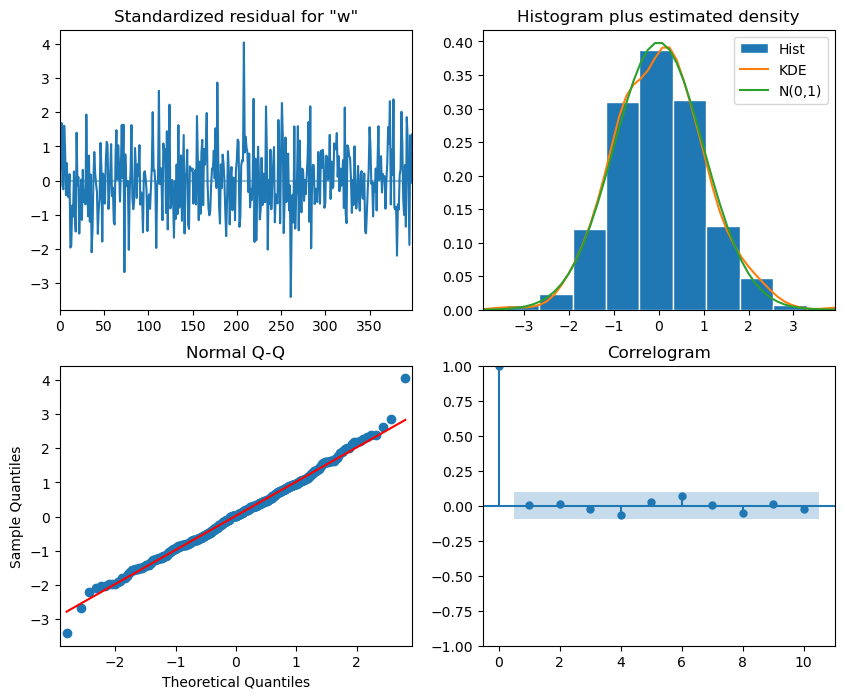

In [34]:
#Best model is ARIMA(0,1,2)

ARIMA_model = SARIMAX(train, order=(0,1,2), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.015003   0.902512
2   0.052349   0.974165
3   0.311076   0.957932
4   0.359459   0.985660
5   0.360425   0.996350
6   0.856687   0.990467
7   0.962596   0.995410
8   1.044169   0.997954
9   1.084235   0.999218
10  1.130324   0.999699


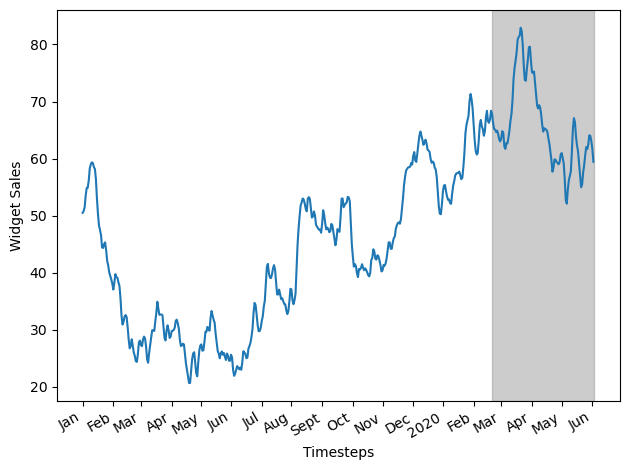

In [36]:
fig, ax = pt.subplots()

ax.plot(MA_data['widget_sales'])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Widget Sales')
ax.axvspan(400,500, color="#808080", alpha=0.4)
pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])
fig.autofmt_xdate()
pt.tight_layout()

In [37]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,1,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [38]:
TRAIN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(MA_data, TRAIN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(MA_data, TRAIN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(MA_data, TRAIN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last'] = pred_last
test['pred_ARIMA'] = pred_ARIMA

test.head()

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\2863454493.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\2863454493.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last'] = pred_last
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\2863454493.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,widget_sales,pred_mean,pred_last,pred_ARIMA
400,67.877005,42.287638,68.391760,69.472544
401,66.213990,42.287638,68.391760,69.776558
402,65.201468,42.410812,66.213990,65.311319
403,65.073355,42.410812,66.213990,65.163873
404,64.667145,42.523319,65.073355,65.141620


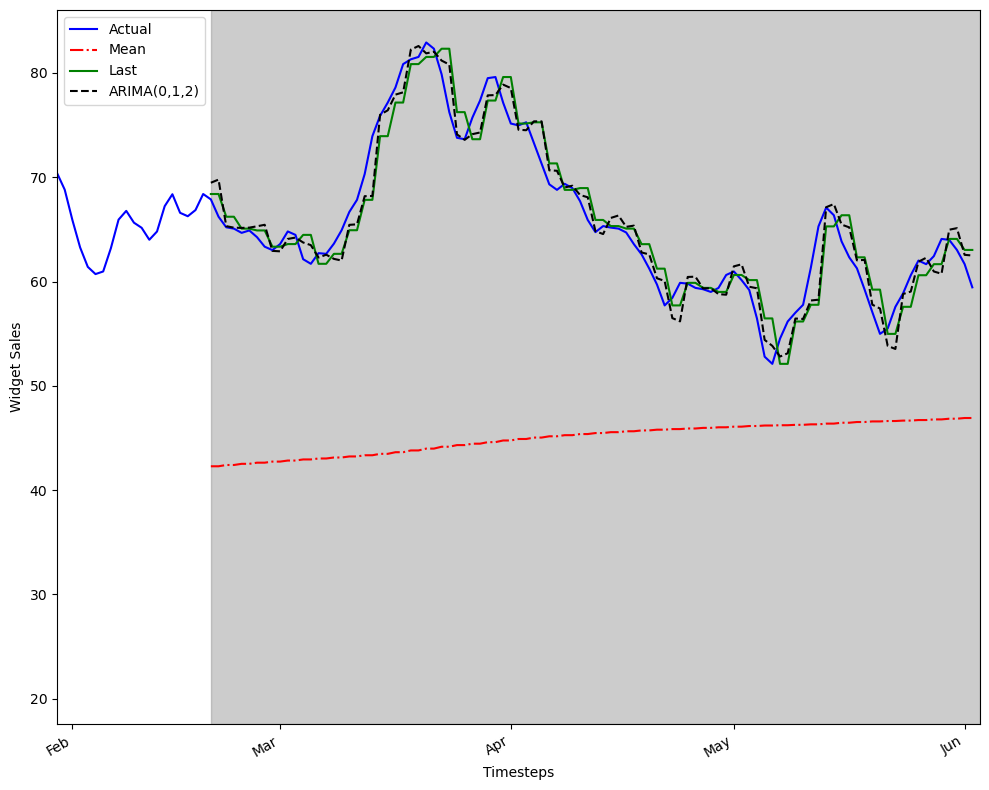

In [39]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(MA_data['widget_sales'], 'b-', label='Actual')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g-', label='Last')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA(0,1,2)')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Widget Sales')
ax.axvspan(400,500, color="#808080", alpha=0.4)
pt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','2020','Feb','Mar','Apr','May','Jun'])
ax.set_xlim(380,500)
fig.autofmt_xdate()
pt.tight_layout()

In [40]:
ARIMA_mape = mape(test['widget_sales'], test['pred_ARIMA'])
mean_mape = mape(test['widget_sales'], test['pred_mean'])
last_mape = mape(test['widget_sales'], test['pred_last'])

print("ARIMA : ", ARIMA_mape)
print("MEAN : ", mean_mape)
print("LAST : ", last_mape)

ARIMA :  2.2980699612171778
MEAN :  30.569810623062782
LAST :  2.8409512895951967


In [41]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])
print(mae)

1.4916636035615614


The ARIMA model on this MA problem has a MAPE of 2.3% and a MAE of 1.5. Meaning that our predictions are 2.3% off or 1.5 value plus minus off the actual value.

# ARMA_data with ARIMA

In [42]:
ARMA_data.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [48]:
ARMA_data.describe()

,hourly_bandwidth
count,10000.000000
mean,1232.634448
std,615.204936
min,193.079868
25%,751.099777
50%,1064.494357
75%,1896.875640
max,2402.361236


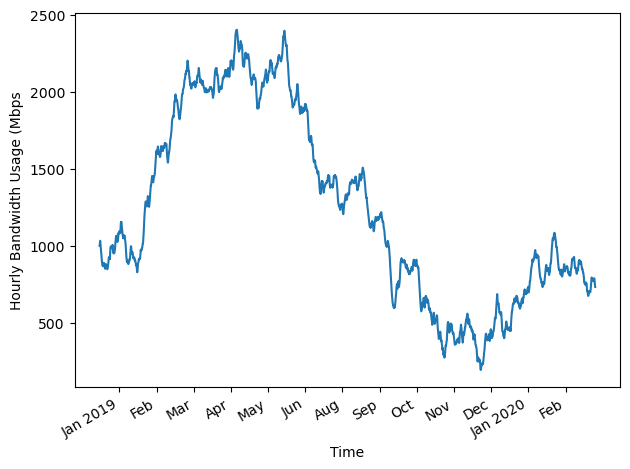

In [43]:
fig , ax = pt.subplots()

ax.plot(ARMA_data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

In [44]:
ADF_result = adfuller(ARMA_data['hourly_bandwidth'])
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-value: {ADF_result[1]}')

 ADF Statistic: -0.8714653199452924
 P-value: 0.7972240255014491


In [45]:
ARMA_data_diff = np.diff(ARMA_data['hourly_bandwidth'], n=1)

In [46]:
ADF_result_diff = adfuller(ARMA_data_diff)
print(f' ADF Statistic: {ADF_result_diff[0]}')
print(f' P-value: {ADF_result_diff[1]}')

 ADF Statistic: -20.694853863789014
 P-value: 0.0


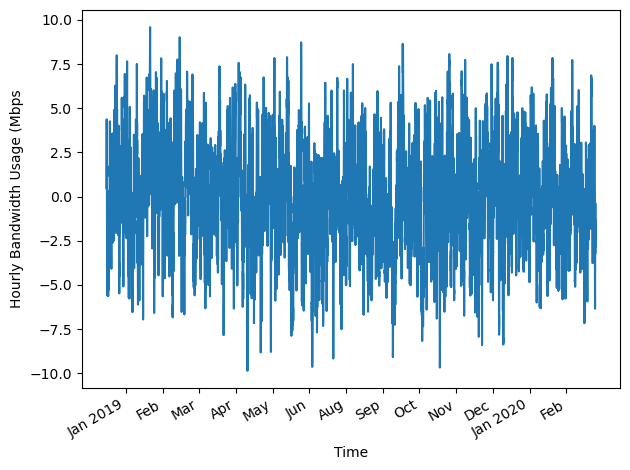

In [47]:
fig , ax = pt.subplots()

ax.plot(ARMA_data_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

In [52]:
train = ARMA_data[:-1000]
test = ARMA_data[-1000:]

print(len(train))
print(len(test))

9000
1000


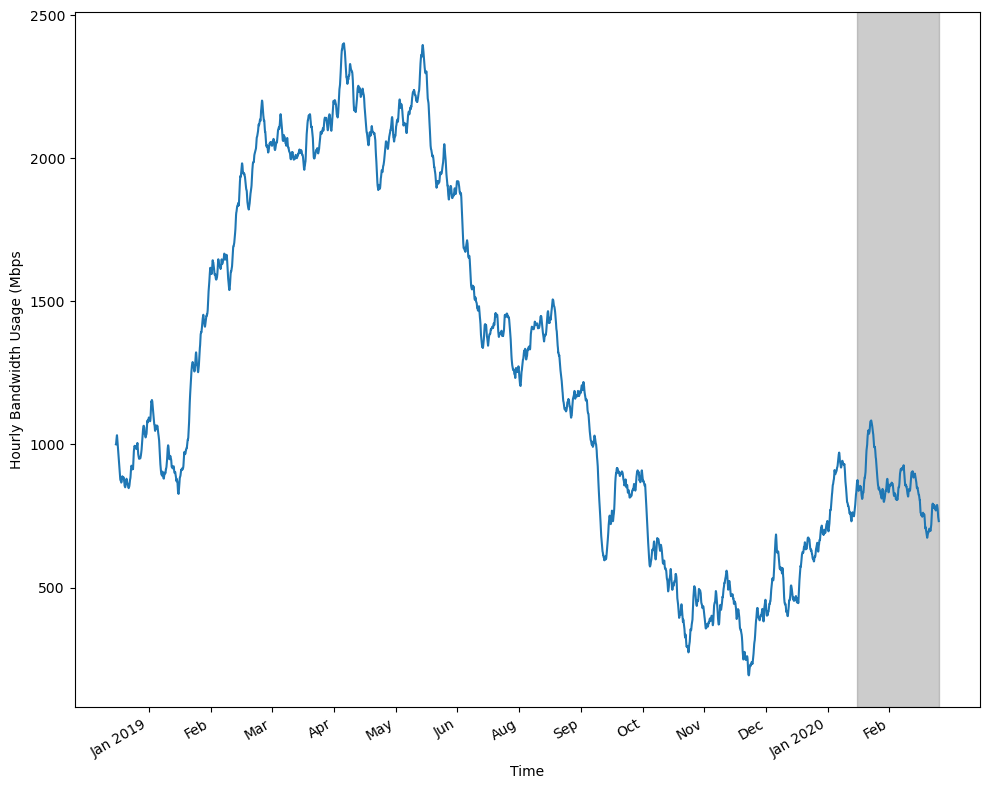

In [55]:
fig , ax = pt.subplots(figsize=(10,8))

ax.plot(ARMA_data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
ax.axvspan(9000,10000, color="#808080", alpha=0.4)
fig.autofmt_xdate()
pt.tight_layout()

In [56]:
ps = range(0,4,1)
qs = range(0,4,1)
d = 1

ARIMA_order_list = list(product(ps,qs))

In [58]:
result_data = optimize_ARIMA(train, ARIMA_order_list, d)
result_data

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\903790325.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list): #iterate over each unique (p,q) combination. Tqdm_notebook will display a progress bar.


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Drew\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(2, 2)",25683.815733
1,"(3, 2)",25684.263741
2,"(2, 3)",25684.323013
3,"(3, 3)",25684.720030
4,"(1, 3)",25694.321140
5,"(1, 2)",25737.598263
6,"(3, 1)",25755.953982
7,"(3, 0)",25780.816687
8,"(2, 1)",25782.123608
9,"(2, 0)",25782.583585


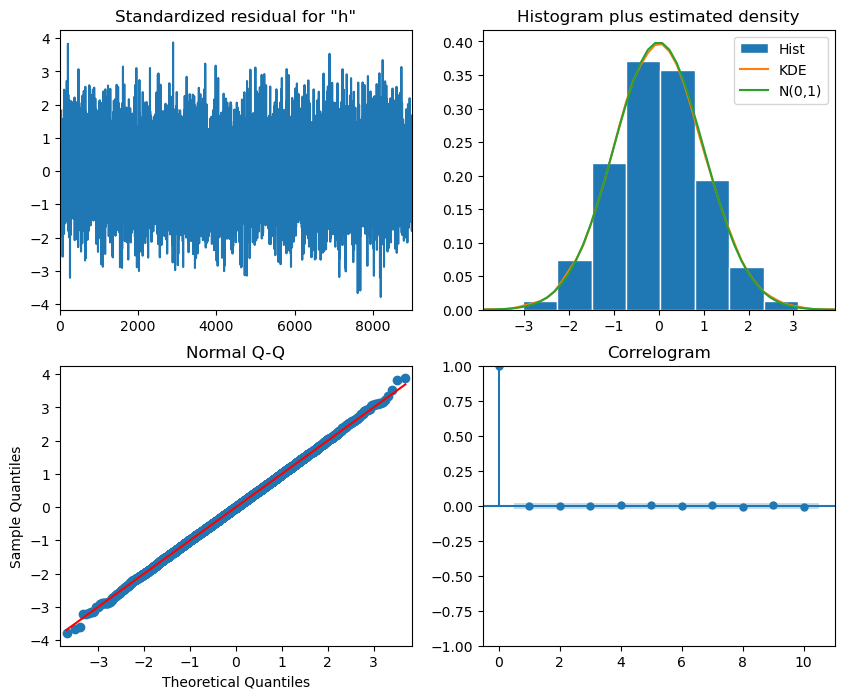

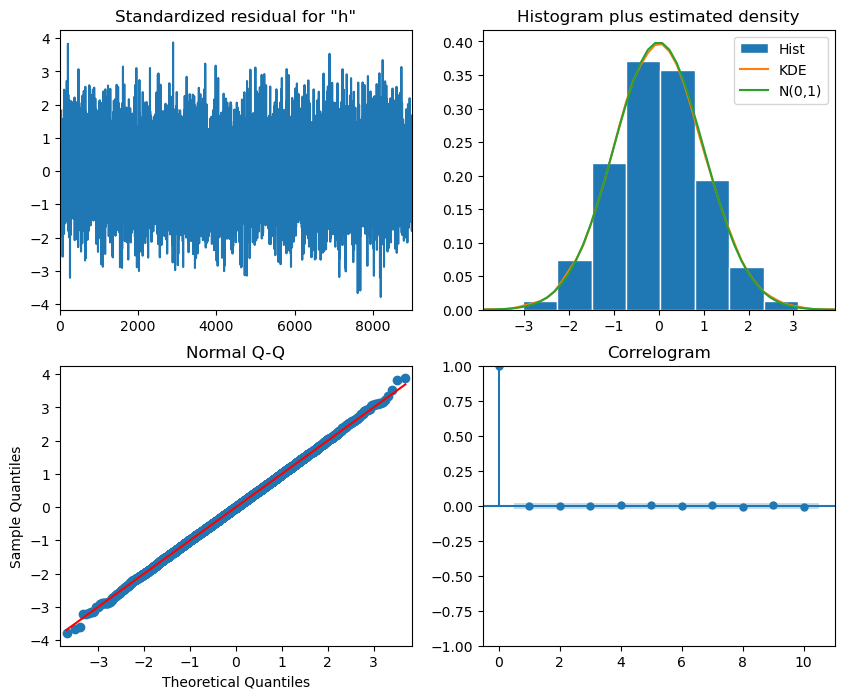

In [60]:
#best model ARIMA(2,1,2)
ARIMA_model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [61]:
residuals = ARIMA_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.001792   0.966236
2   0.004840   0.997583
3   0.023702   0.999036
4   0.023803   0.999930
5   0.024361   0.999995
6   0.046039   0.999998
7   0.052358   1.000000
8   0.054868   1.000000
9   0.057873   1.000000
10  0.060134   1.000000


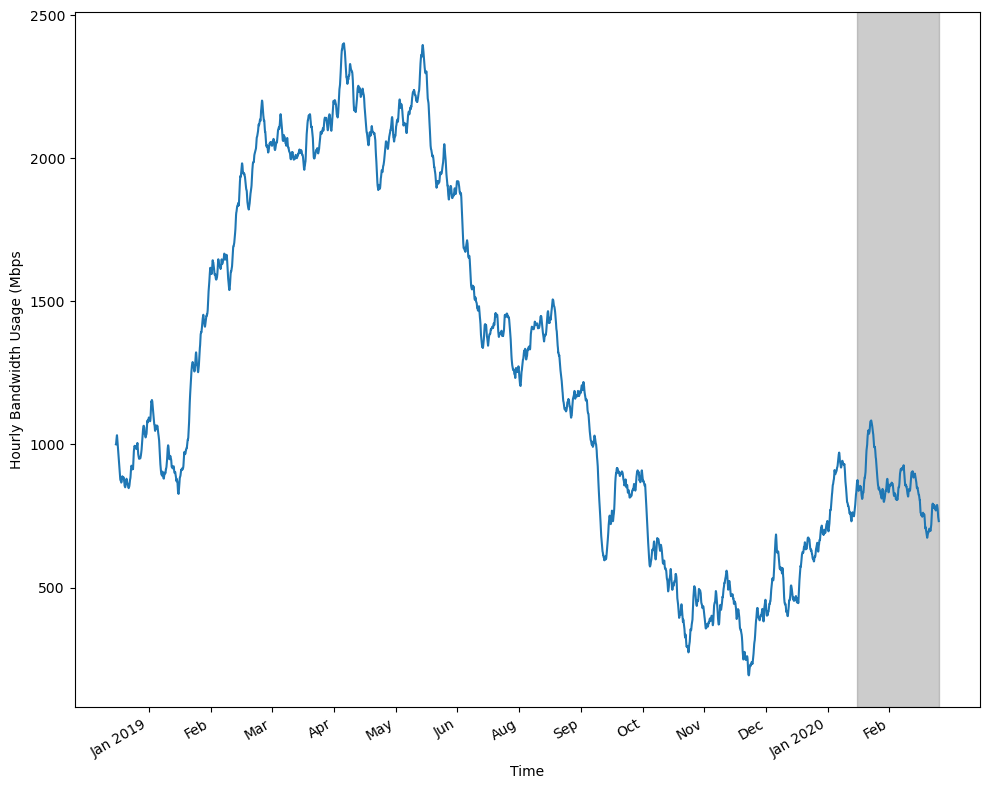

In [64]:
fig , ax = pt.subplots(figsize=(10,8))

ax.plot(ARMA_data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
ax.axvspan(9000,10000, color="#808080", alpha=0.4)
fig.autofmt_xdate()
pt.tight_layout()

In [63]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [65]:
TRAIN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(ARMA_data, TRAIN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(ARMA_data, TRAIN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(ARMA_data, TRAIN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last'] = pred_last
test['pred_ARIMA'] = pred_ARIMA

test.head()

C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\4274839479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\4274839479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last'] = pred_last
C:\Users\Drew\AppData\Local\Temp\ipykernel_45776\4274839479.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,hourly_bandwidth,pred_mean,pred_last,pred_ARIMA
9000,848.353097,1275.050242,843.823606,847.568155
9001,853.879556,1275.050242,843.823606,851.030463
9002,859.662415,1274.956056,853.879556,859.147412
9003,863.162335,1274.956056,853.879556,863.928780
9004,865.454674,1274.864198,863.162335,865.626191


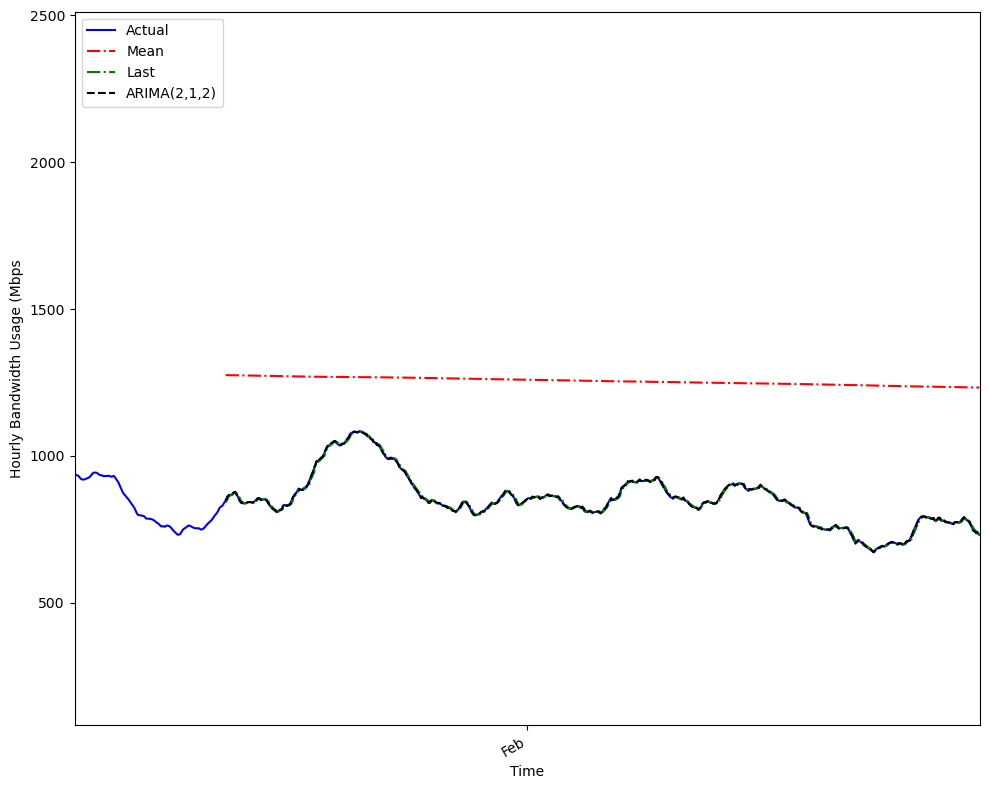

In [67]:
fig, ax = pt.subplots(figsize=(10,8))

ax.plot(ARMA_data['hourly_bandwidth'], 'b-', label='Actual')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g-.', label='Last')
ax.plot(test['pred_ARIMA'], 'k--', label='ARIMA(2,1,2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth Usage (Mbps')
pt.xticks(np.arange(400, 10000, 750),
          ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
ax.set_xlim(8800,10000)
fig.autofmt_xdate()
pt.tight_layout()

In [68]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [69]:
ARIMA_mape = mape(test['hourly_bandwidth'], test['pred_ARIMA'])
mean_mape = mape(test['hourly_bandwidth'], test['pred_mean'])
last_mape = mape(test['hourly_bandwidth'], test['pred_last'])

print("ARIMA: ", ARIMA_mape)
print("Mean: ", mean_mape)
print("Last: ", last_mape)

ARIMA:  0.1590566161174744
Mean:  48.88801030695606
Last:  0.35438720226990233


In [70]:
from sklearn.metrics import mean_absolute_error

In [73]:
ARIMA_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_ARIMA'])
last_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_last'])
print("ARIMA MAE: ", ARIMA_mae)
print("LAST MAE: ", last_mae)

ARIMA MAE:  1.3432689964111164
LAST MAE:  3.011563527618536


The ARIMA(2,1,2) model achieves the best performance, since it has the lowest MAE with a 0.15% of Mean Absolute Percentage Error and 1.3 plus minus off from the actual predictions.

# Is ARIMA Model the solution to every problem? 

From this exercise, we've performed forecasting with ARIMA model on the previous chapters of time series data using MA, AR, and ARMA. As a result, ARIMA model achieves the best performance in every of these comparisons. So, is ARIMA model the solution to every problem? By every problem, I mean MA suited problems, AR suited problems, and ARMA suited problems. 

It is not necessarily the case. It depends on scenarios. ARIMA as a whole has a lot of advantages over MA, AR, and ARMA model itselves. Since ARIMA model is a complex time series model, it allows ARIMA to capture more complex patterns and dynamics from short term dependencies to long term dependencies. While AR, MA, and ARMA only consider short-term dependencies. ARIMA model has alot of flexibility in as well by adjusting to different levels of complexity by varying the orders of AR(p), MA(q), Differencing(d) components. It allows ARIMA to adapt to a wide range of time series data potentially leading to better predictions in diverse forecasting scenarios. Also, ARIMA can capture trends and other long-term patterns that may be missed by simpler models. And of course, ARIMA can perform on non-stationary time series data.

The downside of ARIMA model compare to AR, MA and ARMA model is as I mentioned already, depending on scenarios. ARIMA model can be complex and difficult to interpret compared to simple models such as AR, MA, ARMA. The inclusion of AR, I, and MA components as well as selection of appropriate orders for these components may require more advanced statistical knowledge and expertise. Moreover, ARIMA can be computationally intensive especially for large datasets or models with high orders of AR and MA components. This computational complexity may limit the scalability of ARIMA compared to simpler models.

In short, ARIMA generally offers alot of advantages over AR, MA, and ARMA specifically forecasting accuracy due to their ability to capture complex patterns and flexibility. However, the drawbacks of ARIMA model is due to computational intensity and model complexity. The choice between ARIMA, and simpler models (AR, MA, ARMA) depends on the specific characteristics of the time series data and the forecasting objectives, as well as considerations of model interpretability and computational resources.